# Exploring the critical community size of an SIR model

Use multiple nodes with no connection to identify the critical community size and its dependence on disease and demographic parameters

In [1]:
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
import matplotlib.pyplot as plt
import os
from scipy.optimize import fsolve

from laser_generic import Model
from laser_generic import Infection
from laser_generic import Susceptibility
from laser_generic import Transmission
from laser_generic import Births_ConstantPop
from laser_generic.importation import Infect_Agents_In_Patch

from laser_generic.utils import set_initial_susceptibility_in_patch
from laser_generic.utils import seed_infections_in_patch

%load_ext line_profiler

f"{np.__version__=}"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


"np.__version__='1.26.4'"

In [ ]:
%%capture

nticks = 50*365
npatches = 61
pops = np.logspace(3, 6, npatches)
scenario = pd.DataFrame({
    "name": [str(i) for i in range(npatches)],
    "population": pops
})

#np.random.seed(5)  # Ensure reproducibility
nsims = 200
R0_samples = np.random.uniform(3, 16, nsims)
infmean_samples = 5+np.random.gamma(2, 10, nsims)
cbr_samples = 10+np.random.gamma(2, 20, nsims)
i = 0
outputs = np.zeros((nsims, nticks, npatches))
# Create a folder to store the outputs
output_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'laser-generic-outputs', 'CCSSIRoutputs2'))
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
for R0, infmean, cbr in zip(R0_samples, infmean_samples, cbr_samples):
    parameters = PropertySet({"seed": np.random.randint(0, 1000000),
                            "nticks": nticks,
                            "verbose": True, 
                            "beta": R0/infmean,
                            "inf_mean": infmean,
                            "cbr": cbr, 
                            "importation_period": 180, 
                            "importation_end": 20*365
                            })

    mu = ((1+parameters.cbr/1000)**(1/365)-1) 

    model = Model(scenario, parameters)
    model.components = [Births_ConstantPop,
        Susceptibility,
        Transmission,
        Infection,
        Infect_Agents_In_Patch,
    ]   

    #Start them slightly asynchronously - different initial susceptibilities, infection only in 1 patch
    #Want to see how connectivity drives correlation over time.
    for j in range(npatches):
        set_initial_susceptibility_in_patch(model, j, 1/R0+.1/R0*np.random.normal())

    model.run()
    outputs[i, :, :] = model.patches.cases
    np.save(f"{output_folder}/CCSSIRoutputs_{i}.npy", outputs[i, :, :])
    i+=1



In [4]:
params_df = pd.DataFrame({
    'R0': R0_samples,
    'infmean': infmean_samples,
    'cbr': cbr_samples
})

params_df.to_csv(os.path.join(output_folder, 'params.csv'), index=False)

Bad pipe message: %s [b'\xe9\xbaU\xd6\xd6\x00\xc4y{\xbc\x06,\x8f\xd4']
Bad pipe message: %s [b'\xb1\xf6\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0', b'\x04\xc0']
Bad pipe message: %s [b'\x06\xc0\x07\xc0']
Bad pipe message: %s [b'\t\xc0\n\xc0\x0b\xc0\x0c']
Bad pipe message: %s [b'\xcd\xa3\x18\xc0\x8e.\x01\x8a\xad

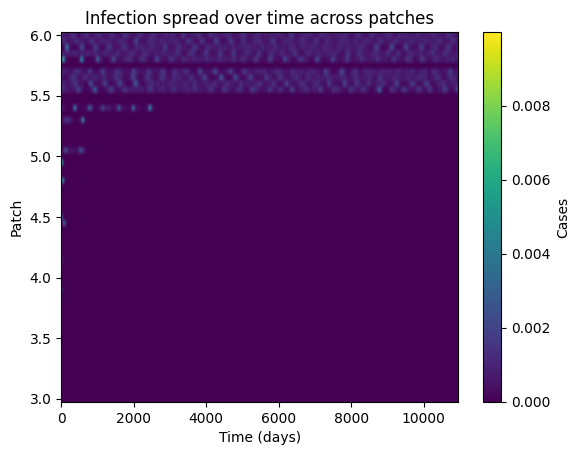

In [43]:
plt.imshow(outputs[26, 7300:, :].T/pops[:, np.newaxis], aspect='auto', origin='lower')
plt.colorbar(label='Cases')
plt.xlabel('Time (days)')
plt.ylabel('Patch')
plt.yticks(range(0, npatches, 10), np.log10(pops[::10]))
plt.title('Infection spread over time across patches')
plt.show()

In [6]:
output_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'laser-generic-outputs', 'CCSSIRoutputs2'))
params_df = pd.read_csv(os.path.join(output_folder, 'params.csv'))

outputs = []
nsims = 200
npatches = 61
pops = np.logspace(3, 6, npatches)

for i in range(nsims):
    output_file = os.path.join(output_folder, f'CCSSIRoutputs_{i}.npy')
    outputs.append(np.load(output_file))

outputs = np.array(outputs)

In [7]:
CCS1 = []
CCS2 = []

for sim in range(nsims):
    end_output = outputs[sim, -1, :]
    zero_pops = pops[end_output == 0]
    nonzero_pops = pops[end_output != 0]
    
    if len(zero_pops) > 0:
        CCS2.append(np.max(zero_pops))
    else:
        CCS2.append(None)
    
    if len(nonzero_pops) > 0:
        CCS1.append(np.min(nonzero_pops))
    else:
        CCS1.append(None)

results_df = pd.DataFrame({
    'largest_zero_pop': CCS2,
    'smallest_nonzero_pop': CCS1
})

print(results_df)

     largest_zero_pop  smallest_nonzero_pop
0        79432.823472          22387.211386
1       158489.319246         100000.000000
2        79432.823472          35481.338923
3       141253.754462          39810.717055
4       125892.541179          89125.093813
..                ...                   ...
195     125892.541179         141253.754462
196     158489.319246          79432.823472
197     891250.938134         251188.643151
198     707945.784384         794328.234724
199     794328.234724         281838.293126

[200 rows x 2 columns]


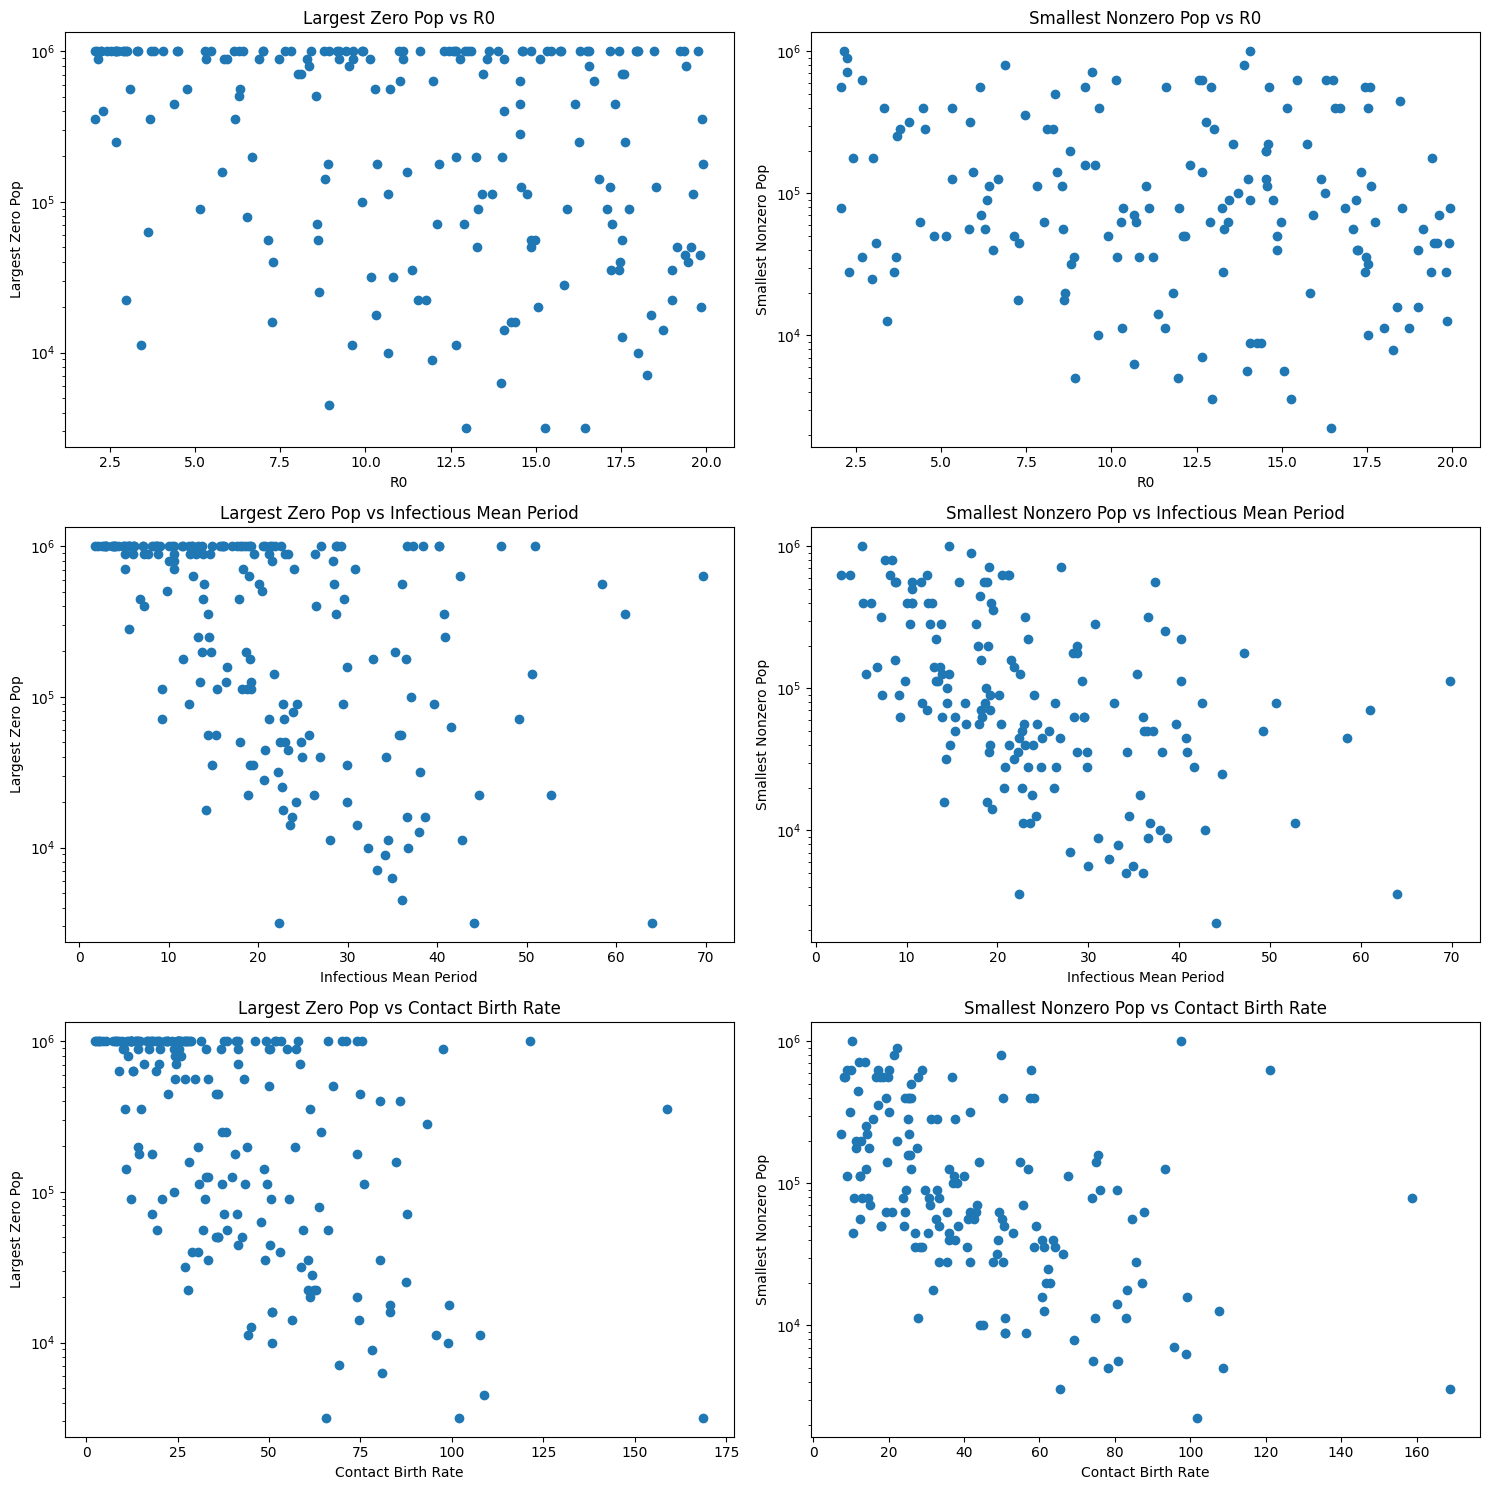

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot largest_zero_pop against R0, infmean, and cbr
axs[0, 0].scatter(params_df['R0'], results_df['largest_zero_pop'])
axs[0, 0].set_xlabel('R0')
axs[0, 0].set_ylabel('Largest Zero Pop')
axs[0, 0].set_title('Largest Zero Pop vs R0')
axs[0, 0].set_yscale('log')

axs[1, 0].scatter(params_df['infmean'], results_df['largest_zero_pop'])
axs[1, 0].set_xlabel('Infectious Mean Period')
axs[1, 0].set_ylabel('Largest Zero Pop')
axs[1, 0].set_title('Largest Zero Pop vs Infectious Mean Period')
axs[1, 0].set_yscale('log')

axs[2, 0].scatter(params_df['cbr'], results_df['largest_zero_pop'])
axs[2, 0].set_xlabel('Contact Birth Rate')
axs[2, 0].set_ylabel('Largest Zero Pop')
axs[2, 0].set_title('Largest Zero Pop vs Contact Birth Rate')
axs[2, 0].set_yscale('log')

# Plot smallest_nonzero_pop against R0, infmean, and cbr
axs[0, 1].scatter(params_df['R0'], results_df['smallest_nonzero_pop'])
axs[0, 1].set_xlabel('R0')
axs[0, 1].set_ylabel('Smallest Nonzero Pop')
axs[0, 1].set_title('Smallest Nonzero Pop vs R0')
axs[0, 1].set_yscale('log')

axs[1, 1].scatter(params_df['infmean'], results_df['smallest_nonzero_pop'])
axs[1, 1].set_xlabel('Infectious Mean Period')
axs[1, 1].set_ylabel('Smallest Nonzero Pop')
axs[1, 1].set_title('Smallest Nonzero Pop vs Infectious Mean Period')
axs[1, 1].set_yscale('log')

axs[2, 1].scatter(params_df['cbr'], results_df['smallest_nonzero_pop'])
axs[2, 1].set_xlabel('Contact Birth Rate')
axs[2, 1].set_ylabel('Smallest Nonzero Pop')
axs[2, 1].set_title('Smallest Nonzero Pop vs Contact Birth Rate')
axs[2, 1].set_yscale('log')

plt.tight_layout()
plt.show()

/var/folders/1b/yq6gx3hj51jf_v98kwv057xh0000gn/T/ipykernel_3510/402221576.py:11: UserWarning: Attempt to set non-positive zlim on a log-scaled axis will be ignored.
  ax1.set_zscale('log')
/Users/kevinmccarthy/Documents/GitHub/laser-generic/.venv/lib/python3.11/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/var/folders/1b/yq6gx3hj51jf_v98kwv057xh0000gn/T/ipykernel_3510/402221576.py:22: UserWarning: Attempt to set non-positive zlim on a log-scaled axis will be ignored.
  ax2.set_zscale('log')


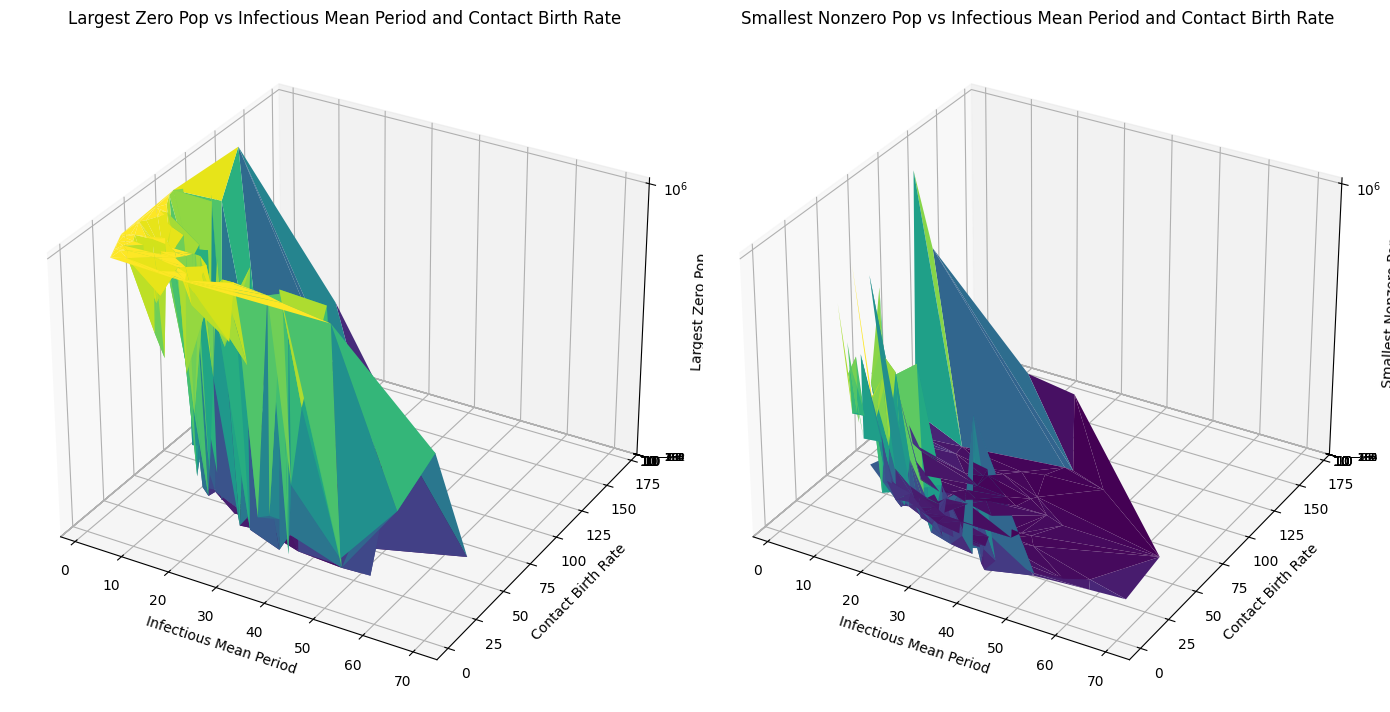

Bad pipe message: %s [b'\xdb\xef8\xca\xd7\xb9\x8c1\xd7r\xfek\xe3w\x8a]\xb8\xdd']
Bad pipe message: %s [b'\xc4L\xe2\x85jS`\xad\x831\xb6\xa6\x80-\xaalA\xa7\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00']
Bad pipe message: %s [b'\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 7))

# Surface plot for largest_zero_pop
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(params_df['infmean'], params_df['cbr'], results_df['largest_zero_pop'], cmap='viridis')
ax1.set_xlabel('Infectious Mean Period')
ax1.set_ylabel('Contact Birth Rate')
ax1.set_zlabel('Largest Zero Pop')
ax1.set_zscale('log')

ax1.set_title('Largest Zero Pop vs Infectious Mean Period and Contact Birth Rate')

# Surface plot for smallest_nonzero_pop
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(params_df['infmean'], params_df['cbr'], results_df['smallest_nonzero_pop'], cmap='viridis')
ax2.set_xlabel('Infectious Mean Period')
ax2.set_ylabel('Contact Birth Rate')
ax2.set_zlabel('Smallest Nonzero Pop')
ax2.set_title('Smallest Nonzero Pop vs Infectious Mean Period and Contact Birth Rate')
ax2.set_zscale('log')
plt.tight_layout()
plt.show()

Optimal parameters: constant = 1033750855.0093409, a = -1.4116195671076526, b = 1.0949091913715039


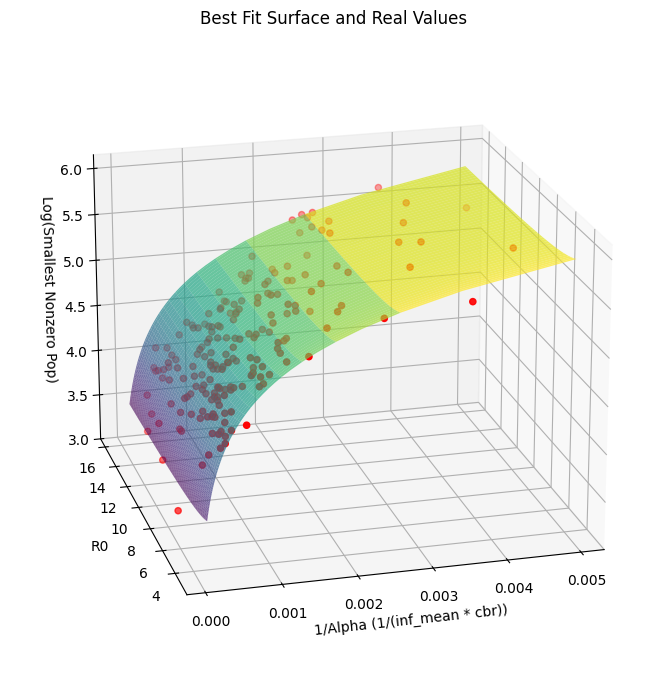

In [32]:
# from scipy.optimize import curve_fit

# # Calculate alpha
# alpha = params_df['infmean'] * params_df['cbr']
# R0 = params_df['R0']

# # Define the fitting function
# def fitting_function(alpha, R0, constant, a, b, c):
#     return constant * alpha**a * (R0)**b * (R0-1)**c

# # Prepare the data for fitting'
# # Drop NA values from smallest_nonzero_pop and corresponding entries from alpha and R0
# valid_indices = ~results_df['smallest_nonzero_pop'].isna()
# alpha_values = alpha[valid_indices].values
# R0_values = params_df['R0'][valid_indices].values
# smallest_nonzero_pop_values = results_df['smallest_nonzero_pop'][valid_indices].values


# # Fit the function to the data
# popt, pcov = curve_fit(lambda alpha, constant, a, b, c: fitting_function(alpha, R0_values, constant, a, b, c), alpha_values, smallest_nonzero_pop_values)

# # Extract the optimal parameters
# constant_opt, a_opt, b_opt, c_opt = popt
print(f"Optimal parameters: constant = {constant_opt}, a = {a_opt}, b = {b_opt}")
# # Plot smallest_nonzero_pop against alpha
# plt.figure()

# # Plot the best fit line
# # 
# # Create a meshgrid for alpha and R0 values
# alpha_fit = np.linspace(min(alpha_values), max(alpha_values), 100)
# R0_fit = np.linspace(min(R0_values), max(R0_values), 100)
# alpha_fit, R0_fit = np.meshgrid(alpha_fit, R0_fit)

# # Calculate the best fit surface
# best_fit_surface = fitting_function(alpha_fit, R0_fit, constant_opt, a_opt, b_opt)

# Plot the best fit surface
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')

# Calculate 1/alpha
inv_alpha_fit = 1 / alpha_fit
inv_alpha_values = 1 / alpha_values

# Plot the best fit surface
ax.plot_surface(inv_alpha_fit, R0_fit, np.log10(best_fit_surface), cmap='viridis', alpha=0.7)

# Scatter the real values for comparison
ax.scatter(inv_alpha_values, R0_values, np.log10(smallest_nonzero_pop_values), color='red', label='Real Values')

ax.set_xlabel('1/Alpha (1/(inf_mean * cbr))')
ax.set_ylabel('R0')
ax.set_zlabel('Log(Smallest Nonzero Pop)')
ax.set_title('Best Fit Surface and Real Values')

# Add the best fit equation as a textbox
equation_text = f"Best fit: y = {constant_opt:.2e} * alpha^{a_opt:.2f} * (R0/(R0-1))^{b_opt:.2f}"
#plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
# Rotate the camera for a better viewing angle
ax.view_init(elev=20, azim=255)
plt.show()

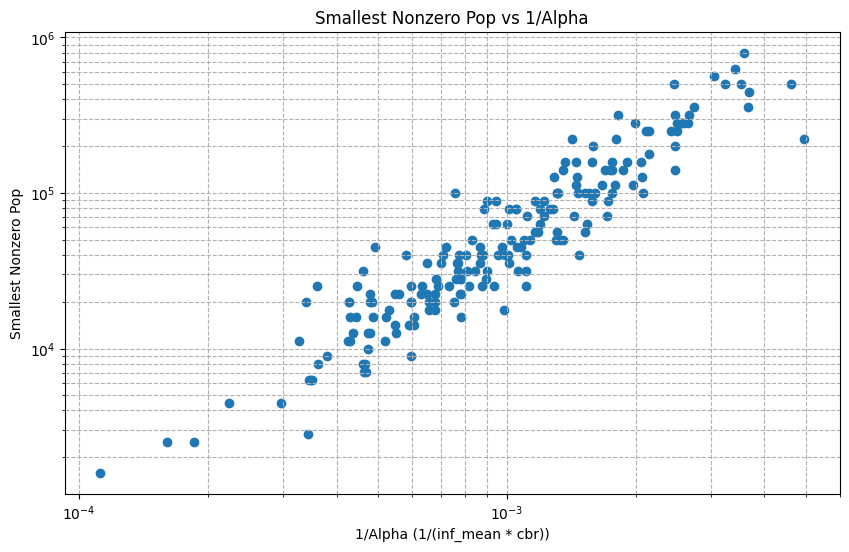

Bad pipe message: %s [b'\x1eC\x82\xb9\xf3\x19\x9f\x95\xfaS\xb0g\x9aC{\xa5\xff\x12\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03']
Bad pipe message: %s [b'\x9d.\xa7\x9b\xf2\x92\x95\x18s\xb0\xba\xce<\x12\xf7\xc4Qo\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(inv_alpha_values, smallest_nonzero_pop_values)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('1/Alpha (1/(inf_mean * cbr))')
plt.ylabel('Smallest Nonzero Pop')
plt.title('Smallest Nonzero Pop vs 1/Alpha')
plt.grid(True, which="both", ls="--")
plt.show()

In [27]:
output_folder = "..\..\laser-generic-outputs\CCSSIRoutputs"

['twopatchSIRoutputs', 'CCSSIRoutputs']
